# Introduction

This notebook builds a MLP neural net from simulation data, and then transpiles it to HLS. This can then be imported by M3602A/PathWave, and synthesized and deployed on an FPGA. This is the full pipeline, with simulation providing the training data for the neural net. `experiment_pipeline.ipynb` contains similar code, except it trains the network on experimental data. 

# Qubit-Resonator Simulation

In [1]:
!pip install qutip hls4ml

import matplotlib.pyplot as plt
import numpy as np
import qutip, defs, helpers_qutip, os
import hls4ml

# QuTip Settings
qutip.settings.num_cpus = os.cpu_count()

     |████████████████████████████████| 14.8 MB 29.7 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## Obtain Trajectories (load them if on disk, otherwise recompute them)

In [2]:
# load datasets from disk if they exist, otherwise compute them

path = 'datasets/trajectory_time.npy'
if os.path.exists(path):
    trajectory_time = np.load('datasets/trajectory_time.npy')
    z_plus_sigma_z = np.load('datasets/z_plus_sigma_z.npy')
    z_minus_sigma_z = np.load('datasets/z_minus_sigma_z.npy')
    z_plus_r_t = np.load('datasets/z_plus_r_t.npy')
    z_minus_r_t = np.load('datasets/z_minus_r_t.npy')
    n_traj = z_minus_r_t.shape[0]
    print(f"Loaded from disk, {n_traj} trajectories present.")

else:
    os.makedirs('datasets/')
    
    # load QuTip definitions
    p = defs.get_parameters(num_sites=1, num_fock=[5])
    ops = helpers_qutip.Operators(p, swap_tensor_order=True)
    hamiltonian = defs.get_hamiltonian(p, ops)    
    c_ops = defs.get_collapse_operators(p, ops)

    # time-evolution
    state_plus_z  = defs.get_initial_state(p, state_qb='+z_tilde')
    state_minus_z = defs.get_initial_state(p, state_qb='-z_tilde')
    n_traj = 100

    # trajectories
    result_sme_plus_z = helpers_qutip.solve_time_evolution_trajectories(p,
                                                                        hamiltonian,
                                                                        state_plus_z, 
                                                                        [c_ops[1]],
                                                                        sc_ops=[c_ops[0]],
                                                                        ntraj = n_traj,
                                                                        nsubsteps=p.nsubsteps)

    result_sme_minus_z = helpers_qutip.solve_time_evolution_trajectories(p,
                                                                        hamiltonian,
                                                                        state_minus_z, 
                                                                        [c_ops[1]],
                                                                        sc_ops=[c_ops[0]],
                                                                        ntraj = n_traj,
                                                                        nsubsteps=p.nsubsteps)


    # Extract \sigma_z(t) trajectories from SME solution
    #   Note: This only keeps the real part of the trajectory
    #   (on principle it should be real to begin with, but numeric artifacts give a small imaginary part)

    def extract_expect_op_trajectory(result_sme, expect_op):
        return np.array( [qutip.expect(expect_op, _rho) for _rho in result_sme.states] )

    trajectory_time = p.times
    z_plus_sigma_z =  extract_expect_op_trajectory(result_sme_plus_z, ops.Sz[0]) 
    z_minus_sigma_z = extract_expect_op_trajectory(result_sme_minus_z, ops.Sz[0]) 
    np.save('datasets/trajectory_time.npy', trajectory_time)
    np.save('datasets/z_plus_sigma_z.npy',  z_plus_sigma_z)
    np.save('datasets/z_minus_sigma_z.npy', z_minus_sigma_z)

    # Extract r(t) trajectories from SME solution
    z_plus_r_t  = np.real(result_sme_plus_z.measurement)
    z_minus_r_t = np.real(result_sme_minus_z.measurement)
    np.save('datasets/z_plus_r_t.npy',  z_plus_r_t)
    np.save('datasets/z_minus_r_t.npy', z_minus_r_t)

Loaded from disk, 100 trajectories present.


### Plot $r(t)$ for trajectories prepared in $|0\rangle$ and $|1 \rangle$ 

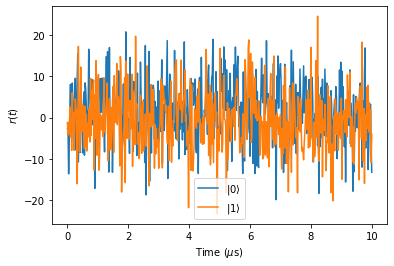

In [3]:
# plot the measurement signal vs timesteps
plt.plot(trajectory_time, z_plus_r_t[0],  label = r'$| 0 \rangle $')  
plt.plot(trajectory_time, z_minus_r_t[1], label = r'$| 1 \rangle $')  
plt.xlabel('Time ($\mu$s)')
plt.ylabel('$r(t)$')
plt.legend()
plt.savefig('figures/r_t.png')
plt.show()

### Plot cumulative integral of $r(t)$ for trajectories prepared in $|0\rangle$ and $|1 \rangle$ 

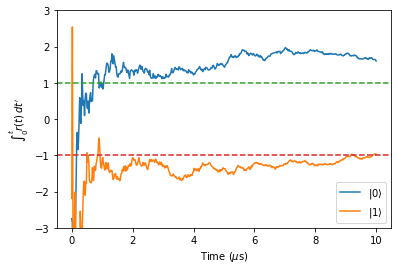

In [4]:
# get integrated "r(t)" for a single trajectory
plt.plot(trajectory_time, np.cumsum(z_plus_r_t[0])/np.arange(1, len(z_plus_r_t[0])+1), label = r'$| 0 \rangle $')
plt.plot(trajectory_time, np.cumsum(z_minus_r_t[3])/np.arange(1, len(z_minus_r_t[3])+1), label = r'$| 1 \rangle $')
plt.axhline(y= 1.0, color='tab:green', linestyle='dashed')
plt.axhline(y=-1.0, color='tab:red',   linestyle='dashed')
plt.ylim(-3,3)
plt.xlabel('Time ($\mu$s)')
plt.ylabel("$\int_{0}^{t} r(t) \,dt'$")
plt.legend()
plt.savefig('figures/int_r_t.png')
plt.show()

### Plot $ \langle \sigma_z \rangle$  for $|0\rangle$ and $|1 \rangle$

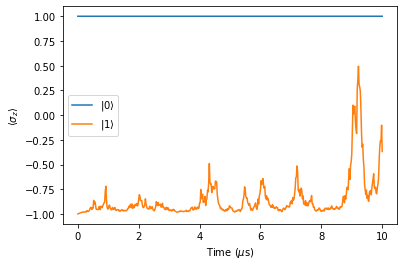

In [5]:
# plot \sigma_z for the same density matrix as above
plt.plot(trajectory_time, z_plus_sigma_z[0], label = r'$| 0 \rangle $')
plt.plot(trajectory_time, z_minus_sigma_z[3], label = r'$| 1 \rangle $')
plt.xlabel('Time ($\mu$s)')
plt.ylabel(r'$\langle \sigma_z \rangle$')
plt.legend()
plt.savefig('figures/int_r_t.png')
plt.show()

# Classifier Creation

## Partition Training/Test Datasets from Simulation

In [6]:
# only train on 80% of the trajectories, leave the rest for testing
n_train_traj = int(n_traj * 0.8)
n_test_traj = n_traj - n_train_traj

train_z_plus_r_t = z_plus_r_t[:n_train_traj,:,0]
train_z_minus_r_t = z_minus_r_t[:n_train_traj,:,0]
assert train_z_plus_r_t.shape == train_z_minus_r_t.shape

test_z_plus_r_t = z_minus_r_t[n_train_traj:,:,0]
test_z_minus_r_t = z_minus_r_t[n_train_traj:,:,0]
assert test_z_plus_r_t.shape == test_z_minus_r_t.shape

## Define Readout Fidelity

In [15]:
def compute_readout_fidelity(classifier, z_plus_r_t, z_minus_r_t, verbose = True):
    # the classifiers take as input a set of z_r_t to classify, and output a list of confidences
    # (between -1 and 1) indicating their best estimate of the qubit state. 
    # they return a list of confidences ranging between -1 and 1

    class_plus = classifier(z_plus_r_t)
    class_minus = classifier(z_minus_r_t)

    # find how many trajectories from one state are being found in the other state
    p_0_1 = np.sum(class_minus >= 0)/z_plus_r_t.shape[0] # frequency of |0> states being found in |1>
    p_1_0 = np.sum(class_plus <= 0)/z_minus_r_t.shape[0] # frequency of |1> states being found in |0>
    fidelity = 1 - p_0_1 - p_1_0

    if verbose:
        print(f'Of {z_plus_r_t.shape[0]} trajectories in |0>, {np.sum(class_minus <= 0)} were found to be in |1>.')
        print(f'Of {z_minus_r_t.shape[0]} trajectories in |1>, {np.sum(class_plus >= 0)} were found to be in |0>.')
        print(f'This corresponds to a readout fidelity of {round(fidelity,3)}')
    
    return p_0_1, p_1_0, fidelity

## Averaging (Box-Car) Classifier

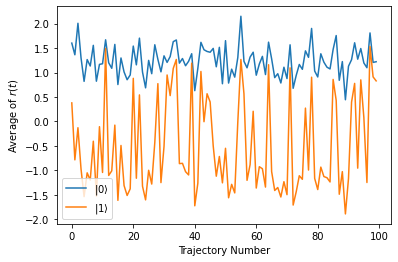

Of 80 trajectories in |0>, 60 were found to be in |1>.
Of 80 trajectories in |1>, 80 were found to be in |0>.
This corresponds to a readout fidelity of 0.75


In [16]:
# define classifier
def average_classifier(r_t, start=None, stop=None):
    if start or stop:
        return r_t[:,start:stop].mean(axis=1)
    
    else:
        return r_t.mean(axis=1)

# run classifier
class_plus = average_classifier(z_plus_r_t)
class_minus = average_classifier(z_minus_r_t)

plt.plot(class_plus, label = r'$| 0 \rangle $')
plt.plot(class_minus, label = r'$| 1 \rangle $')
plt.xlabel("Trajectory Number")
plt.ylabel(r"Average of $r(t)$")
plt.legend()
plt.show()

compute_readout_fidelity(average_classifier, train_z_plus_r_t, train_z_minus_r_t, verbose = True);

### Find optimal integration time, by brute force

Optimal Readout Fidelity: 0.86
Optimal Integration Time: 99


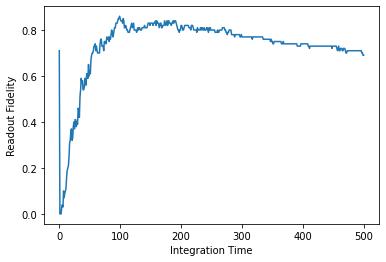

In [17]:
# find the optimal window size to maximize readout fidelity, assuming that integration starts at t=0

fidelities = []
for l in range(z_plus_r_t.shape[1]):
    classifier = lambda z_t: average_classifier(z_t, 0, l)
    p_0_1, p_1_0, fidelity = compute_readout_fidelity(classifier, z_plus_r_t, z_minus_r_t, verbose = False)
    fidelities.append(fidelity)

fidelities = np.array(fidelities)

print(f"Optimal Readout Fidelity: {max(fidelities)}")
print(f"Optimal Integration Time: {np.argmax(fidelities)}")
plt.plot(fidelities)
plt.xlabel("Integration Time")
plt.ylabel("Readout Fidelity")
plt.show()

In [43]:
# find the optimal window size to maximize readout fidelity, assuming that the integration start time is not necessarily at t=0.

opt_fidelity = 0
opt_start = 0
opt_stop = 0

for start in range(0, z_plus_r_t.shape[1]):
    for stop in range(start, z_plus_r_t.shape[1]):
        classifier = lambda z_t: average_classifier(z_t, start, stop)
        p_0_1, p_1_0, fidelity = compute_readout_fidelity(classifier, z_plus_r_t, z_minus_r_t, verbose = False)
        
        if fidelity > opt_fidelity and fidelity < 0.9999:
            opt_start = start
            opt_stop = stop
            opt_fidelity = fidelity

print(f"Optimal Readout Fidelity: {opt_fidelity}")
print(f"Optimal Window: ({opt_start}, {opt_stop})")

# plt.plot(fidelities)
# plt.xlabel("Integration Time")
# plt.ylabel("Readout Fidelity")
# plt.show()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
Optimal Readout Fidelity: 0.87
Optimal Window: (1, 97)


## MLP classification (scikit-learn)

### MLP classification on r(t) directly:

In [23]:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html

from sklearn.neural_network import MLPClassifier
direct_mlp_classifier = MLPClassifier(activation='logistic', hidden_layer_sizes=(100,100,100,100),solver='adam', alpha=1e-5, random_state=1, verbose = False)

X = np.vstack((train_z_plus_r_t, train_z_minus_r_t))
Y = np.concatenate((np.ones(n_train_traj), -np.ones(n_train_traj)))
direct_mlp_classifier.fit(X,Y)

print(f"The classifier's score on the training data is {direct_mlp_classifier.score(X, Y)}")
compute_readout_fidelity(direct_mlp_classifier.predict, test_z_plus_r_t, test_z_minus_r_t, verbose = True);

The classifier's score on the training data is 1.0
Of 20 trajectories in |0>, 15 were found to be in |1>.
Of 20 trajectories in |1>, 5 were found to be in |0>.
This corresponds to a readout fidelity of 0.0


### MLP Classification on cumulative integral of r(t)

In [26]:
# evaluate cumulative integral on the truncated r_t curves for the ground and excited states
def integrate(x):
    integrate_row = lambda row: np.cumsum(row)/np.arange(1, len(row)+1)
    return np.apply_along_axis(integrate_row, 1, x)

int_mlp_classifier = MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100),solver='adam', alpha=1e-5, random_state=1, verbose = False)

X = np.vstack((integrate(train_z_plus_r_t), integrate(train_z_minus_r_t)))
Y = np.concatenate((-np.ones(n_train_traj), np.ones(n_train_traj)))
int_mlp_classifier.fit(X,Y)

print(f"The classifier's score on the training data is {int_mlp_classifier.score(X, Y)}")
compute_readout_fidelity(int_mlp_classifier.predict, test_z_plus_r_t, test_z_minus_r_t, verbose = True);

The classifier's score on the training data is 0.975
Of 20 trajectories in |0>, 5 were found to be in |1>.
Of 20 trajectories in |1>, 15 were found to be in |0>.
This corresponds to a readout fidelity of 0.0
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


## MLP classification (TensorFlow)

11501568/11490434 [==============================] - 0s 0us/step
Feature matrix: (60000, 28, 28)
Target matrix: (10000, 28, 28)
Feature matrix: (60000,)
Target matrix: (10000,)


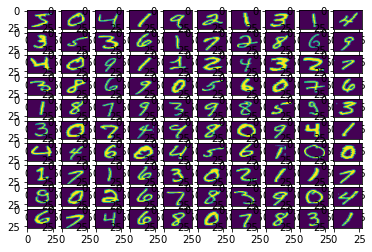

Epoch 1/10
24/24 [==============================] - 2s 49ms/step - loss: 2.1149 - accuracy: 0.3707 - val_loss: 1.7846 - val_accuracy: 0.6832
Epoch 2/10
24/24 [==============================] - 1s 42ms/step - loss: 1.4582 - accuracy: 0.7063 - val_loss: 1.0997 - val_accuracy: 0.7877
Epoch 3/10
24/24 [==============================] - 1s 39ms/step - loss: 0.9170 - accuracy: 0.8044 - val_loss: 0.7123 - val_accuracy: 0.8505
Epoch 4/10
24/24 [==============================] - 1s 40ms/step - loss: 0.6421 - accuracy: 0.8535 - val_loss: 0.5275 - val_accuracy: 0.8811
Epoch 5/10
24/24 [==============================] - 1s 42ms/step - loss: 0.5020 - accuracy: 0.8802 - val_loss: 0.4302 - val_accuracy: 0.8948
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.4228 - accuracy: 0.8931 - val_loss: 0.3726 - val_accuracy: 0.9062
Epoch 7/10
24/24 [==============================] - 1s 39ms/step - loss: 0.3737 - accuracy: 0.9021 - val_loss: 0.3353 - val_accuracy: 0.9125
Epoch 8/10
24

In [32]:
# using an NN trained for MNIST to verify that MLP networks are built properly by HLS4ML
# should just need to modify layer sizes for simulation data.
# https://www.geeksforgeeks.org/multi-layer-perceptron-learning-in-tensorflow/
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Cast the records into float values
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
  
# normalize image pixel values by dividing 
# by 255
gray_scale = 255
x_train /= gray_scale
x_test /= gray_scale

print("Feature matrix:", x_train.shape)
print("Target matrix:", x_test.shape)
print("Feature matrix:", y_train.shape)
print("Target matrix:", y_test.shape)

fig, ax = plt.subplots(10, 10)
k = 0
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(x_train[k].reshape(28, 28), 
                        aspect='auto')
        k += 1
plt.show()


model = Sequential([
    Flatten(input_shape=(28, 28)),    # reshape 28 row * 28 column data to 28*28 rows
    Dense(256, activation='sigmoid'), # dense layer 1
    Dense(128, activation='sigmoid'), # dense layer 2
    Dense(10, activation='sigmoid'),  # output layer 
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=2000, validation_split=0.2)
results = model.evaluate(x_test,  y_test, verbose = 0)
print('test loss, test acc:', results)

# HLS Transpilation with HLS4ML

In [39]:
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
#plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='MLP_model/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')

hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)
hls_model.compile()
x_test = np.ascontiguousarray(x_test)
y_hls = hls_model.predict(x_test)

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
Interpreting Sequential
Topology:
Layer name: flatten_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (sigmoid), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (sigmoid), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (sigmoid), layer name: dense_2
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer name: flatten_input, layer type: InputLayer, input shapes: [[None, 28, 28]], output shape: [None, 28, 28]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 28, 28]], output shape: [None, 784]
Layer name: dense, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 256]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 128]
Layer name: dense_2, layer type: Dense, input s

In [40]:
# this will likely fail because Vitis/Vivado HLS isn't installed in this Deepnote Notebook
# but it's included to show how to build the project
hls_model.build(csim=False)
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Exception: Vivado HLS installation not found. Make sure "vivado_hls" is on PATH.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0211f19d-54e4-44e5-ab1c-ce7a6a2d44df' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>